# Solving the 1D Diffusion Equation with a Neural Network

In [2]:
import torch
from torch import nn
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [3]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [4]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

### 1D Diffusion Equation

In [18]:
# Functions below specify the initial boundary value problem (in terms of its residuals/deviations) alongside its analytic solution

def unpack_sample(xt):
    return xt[:,0].reshape(-1,1), xt[:,-1].reshape(-1,1)

def u0(u, x, t):
    return u - torch.sin(torch.pi * x), torch.zeros_like(u)

def dirichlet_bc(u, x, t):
    return u, torch.zeros_like(u)

def diffusion_equation(u, x, t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t, torch.zeros_like(u)
diffusion_equation.domain_dim=2
diffusion_equation.target_dim=1

def u_analytical(x, t):
    return np.sin(np.pi * x) *np.exp(-(torch.pi)**2 * t)

def spatio_temporal_sample(T, N_st, N_s, N_t, kind="lhs"):
    if kind == "lhs":
        sampler1d = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N))
        # Excludes boundaries naturally
        sampler2d = lambda N: torch.from_numpy(LatinHypercube(2).random(n = N))
    elif kind == "uniform":
        sampler1d = lambda N: torch.from_numpy(np.linspace(0, 1, N).reshape(-1,1))
        # Drop first and last
        sampler2d = lambda N: torch.from_numpy(np.dstack(np.meshgrid(sampler1d(N+2)[1:-1], 
                                                                     sampler1d(N+1)[1:])).reshape(-1, 2))
        N_st = int(np.sqrt(N_st))
        N_s = N_s // 2
    
    #Interior points
    samples_xt = sampler2d(N_st)
    #samples_x = samples_xt[:,0].reshape(-1,1)
    #samples_t = T * samples_xt[:,1].reshape(-1,1)
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = sampler1d(N_t)
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.repeat_interleave(T * sampler1d(N_s), 2, dim=0)
    samples_x_bc = torch.empty((2 * N_s,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)

## Proof of Concept

### Generate Test/Train Split

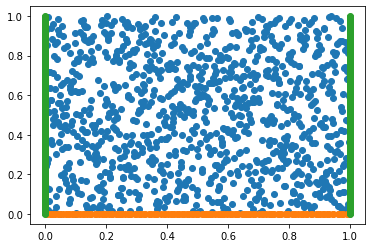

In [21]:
#IBVP parameters
T = 1
N_interior =  2**10
N_bc = 2**9
N_ic = 2**7

# Generate training set
X_train = spatio_temporal_sample(T, N_interior, N_bc, N_ic, kind="lhs")
xt_int, xt_ic, xt_bc = X_train

# Generate test data
X_test = spatio_temporal_sample(T, N_interior, N_bc, N_ic)

plt.scatter(*unpack_sample(xt_int))
plt.scatter(*unpack_sample(xt_ic))
plt.scatter(*unpack_sample(xt_bc))
#plt.scatter(x_boundary2, t_boundary, c="green")
plt.show()

### Training of the Network

In [22]:
diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, verbose=True)
diffusion_nn.fit(X_train, None)

---------------------------Hyperparameters----------------------------
# of collocation points per batch:                                1024
# of boundary points per batch:                                   1024
# of initial condition points per batch:                           128
# of minbatches:                                                     1
Points per Iteration:                                        134217728
Iterations:                                                        100
Total number of collocation points                         13421772800
----------------------------------------------------------------------
  Epoch   |  Total Loss   |  Loss (PDE)   |   Loss (BC)   |   Loss (IC)   
    0     |   1.772720e-01|   1.912597e-02|   5.013990e-02|   1.080062e-01
    10    |   1.217263e-04|   6.323469e-05|   5.333939e-05|   5.152205e-06
    20    |   1.785169e-05|   1.365883e-05|   3.751785e-06|   4.410713e-07
    30    |   5.487533e-06|   4.649319e-06|   7.633898e-07|  

### Comparison between PiNN and Analytical Solution

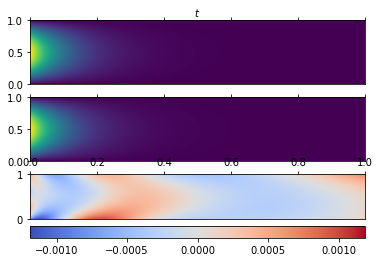

In [23]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, 1, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

X_test = torch.from_numpy(xt)
u_net = diffusion_nn.predict(X_test).reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
fig.add_axes(cax)
cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()

## Parameter Study

In [16]:
a = torch.arange(4)
print(torch.vstack((a,a)).T)

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]])


In [10]:
xt = torch.vstack((torch.arange(5), 2 * torch.arange(5))).T.float()
xt.requires_grad_(True)
print(xt)
x = xt[:,0].reshape(-1,1)
t = xt[:,1].reshape(-1,1)
u = 2 * xt[:,0] * xt[:,1]
print(u)
u_x = derivative(u, x)
print(u_x)

tensor([[0., 0.],
        [1., 2.],
        [2., 4.],
        [3., 6.],
        [4., 8.]], dtype=torch.float32, requires_grad=True)
tensor([ 0.,  4., 16., 36., 64.], dtype=torch.float32, grad_fn=<MulBackward0>)


IndexError: too many indices for tensor of dimension 1

In [21]:
def grid_search(model, hyperparameters, metric, ):
    metric_grid = np.empty(hyperparam)

AttributeError: 'tuple' object has no attribute 'shape'

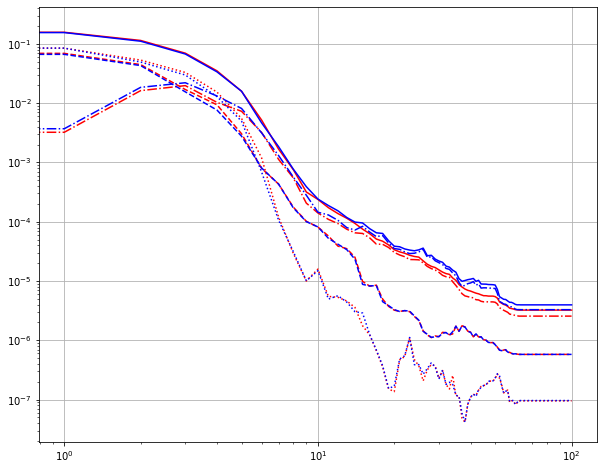

In [81]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xscale("log")
ax.set_yscale("log")
epoch = np.arange(len(mse_test))
mse_train = np.array(mse_train)
mse_test = np.array(mse_test)
ax.plot(epoch, mse_train[:,0], color="red", ls="solid")
ax.plot(epoch, mse_train[:,1], color="red", ls="dashdot")
ax.plot(epoch, mse_train[:,2], color="red", ls="dashed")
ax.plot(epoch, mse_train[:,3], color="red", ls="dotted")

ax.plot(epoch, mse_test[:,0], color="blue", ls="solid")
ax.plot(epoch, mse_test[:,1], color="blue", ls="dashdot")
ax.plot(epoch, mse_test[:,2], color="blue", ls="dashed")
ax.plot(epoch, mse_test[:,3], color="blue", ls="dotted")
ax.grid(True)
plt.show()